In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie

In [4]:
import jax.random
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun, WeaklyDiagonalControlTerm
import random



In [114]:
import jax.random
from diffrax import (ControlTerm, Euler, Heun, MultiTerm, ODETerm, SaveAt,
                     VirtualBrownianTree, diffeqsolve)
from jax import jit, vmap

import jax
import jax.numpy as jnp
from hflow.data.particles import get_2d_lin, get_ic_lin


def solve_sde(drift, diffusion, t_eval, get_ic, n_samples, dt=1e-2, key=None):

    @jit
    def solve_single(key):
        t0, t1 = t_eval[0], t_eval[-1]
        ikey, skey = jax.random.split(key)
        y0 = get_ic(ikey)
        brownian_motion = VirtualBrownianTree(
            t0, t1, tol=1e-3, shape=y0.shape, key=skey)
        terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(
            diffusion, brownian_motion))
        solver = Euler()
        saveat = SaveAt(ts=t_eval)
        sol = diffeqsolve(terms, solver, t0, t1, dt0=dt,
                          y0=y0, saveat=saveat, max_steps=int(1e6))
        return sol.ys

    if key is None:
        key = jax.random.PRNGKey(random.randint(0, 1e6))
    keys = jax.random.split(key, num=n_samples)
    sols = vmap(solve_single)(keys)

    return sols


In [135]:
from scipy.special import roots_legendre, eval_legendre
def gauss_quadrature_weights_points(n, a=0, b=1):
    points, weights = roots_legendre(n)
    points = 0.5 * (points + 1) * (b - a) + a
    weights = weights * 0.5 * (b - a)
    return points, weights

bs_t = 256
t0, t1 = 0.0, 12
t_eval, t_weights = gauss_quadrature_weights_points(bs_t, a=t0, b=t1)
z, T = jnp.asarray([t0]), jnp.asarray([t1])
t_eval = jnp.concatenate([z, t_eval, T])

t_train = t_eval / t1
t_train = t_train.reshape(-1,1)
t_weights = t_weights / t1
# t_weights = t_weights * t1

In [136]:
# t0, t1 = 0, 5
# bs_t = 512
# t_eval = np.linspace(t0, t1, bs_t)
# t_train = t_eval.reshape(-1,1)
# t_weights = jnp.ones(bs_t-2)/(bs_t-2)

In [137]:
n_samples = 10_000

mu = 0.02
drift, diffusion = get_2d_lin(mu)
sols = solve_sde(drift, diffusion, t_eval, get_ic_lin, n_samples)
sols = rearrange(sols, 'N T D -> T N D')

In [138]:
from hflow.data.utils import normalize
sols, d_shift, d_scale = normalize(
    sols, axis=(0, 1), return_stats=True, method='01')

In [139]:
scatter_movie(sols)

In [227]:
from hflow.net.build import build_colora
from typing import List, Optional

import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

from hflow.net.networks import DNN
from hflow.net.utils import init_net, merge, split

key = jax.random.PRNGKey(random.randint(0,1e8))

x_dim = 2

u_dim = 1

depth = 7
u_layers = ['C', 'C', 'C', 'C', 'C', 'C', 'C']
h_layers = ['D']*4
rank = 3
full = False

lora_filter = ['alpha']

u_hat_config = {'width': 64, 'layers': u_layers}
h_config = {'width': 35, 'layers': h_layers}

hyper_dim = 7

net_u = DNN(**u_hat_config, out_dim=u_dim, period=None, last_activation='tanh')
params_init, u_apply = init_net(net_u, x_dim, key=key)

# split up the params of u into the offline params (theta) and the online params (phi)
phi_init, theta_init = split(params_init, lora_filter)
flat_phi, phi_unravel = ravel_pytree(phi_init)
n_phi = len(flat_phi)

net_h = DNN(**h_config, out_dim=n_phi, period=None, activation='sin')
psi_init, h_fn = init_net(net_h, hyper_dim, key=key)

# now we define a wrapper over the u neural network
# this will allow us to take theta and phi sepearatly
# and then it will automatically merge them and pass the resulting
# combined paramters to u_apply
# it also unravels phi so that we can pass in phi as a vector that is output from h

def build_u_hat(u_apply, phi_unravel):
    def u_hat(theta, phi, *args):
        phi = phi_unravel(phi)
        theta_phi = merge(theta, phi)
        return u_apply(theta_phi, *args)
    return u_hat

u_fn = build_u_hat(u_apply, phi_unravel)

state_0_init = jnp.asarray(np.random.randn(hyper_dim))
params_init = (psi_init, theta_init, state_0_init)


def s(t, x, params):
    psi, theta = params
    phi = h_fn(psi, t)

    return jnp.squeeze(u_fn(theta, phi, x))


In [228]:
    # @jit
    # def rk4(carry, t):
    #     y, t_prev = carry
    #     h = t - t_prev
    #     k1 = fn(t_prev, y)
    #     k2 = fn(t_prev + h / 2, y + h * k1 / 2)
    #     k3 = fn(t_prev + h / 2, y + h * k2 / 2)
    #     k4 = fn(t, y + h * k3)
    #     y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
    #     yd = downsampler(y)
    #     return (y, t), yd

    # (yf, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0])), t)
    # return y


In [229]:

# def generate_states(ts, psi, state_0):
#     def gen(carry, t):
#         prev_state = carry[0]
#         new_state = h_fn(psi, prev_state)
#         return (new_state,), new_state
#     (yf, ), states = jax.lax.scan(gen, (state_0, ), ts)
#     return states


In [230]:
from hflow.data.ode import odeint_euler
def generate_states(ts, psi, state_0):
    def fn(t, y):
        return h_fn(psi, y)
    states = odeint_euler(fn, state_0, ts)
    return states


In [231]:
from jax import jit, jvp, grad, jacrev, jacfwd
from functools import partial
from hflow.misc.jax import hess_trace_estimator

s_dt = jacrev(s, 0)
s_dt_Vx = vmap(s_dt, (None, 0, None))
s_dt_Vx_Vt = vmap(s_dt_Vx, (0, None, None))

s_Vx = vmap(s, in_axes=(None, 0, None))
s_Vx_Vt = vmap(s_Vx, in_axes=(0, None, None))
s_dx = jacrev(s, 1)
s_dx_Vx = vmap(s_dx, in_axes=(None, 0, None))
s_ddx_Vx = vmap(jacfwd(s_dx, 1), (None, 0, None))
s_dt_dx = jacrev(s, (0, 1))
s_dt_dx_Vx = vmap(s_dt_dx, in_axes=(None, 0, None))

trace_dds = hess_trace_estimator(s, argnum=1)
trace_dds_Vx = vmap(trace_dds, (None, None, 0, None))


In [232]:
from jax.experimental.host_callback import id_print, id_tap

import jax.flatten_util


noise = 0.0
sigma = 1e-1


res = []
def save_on_host(data, transforms):
    res.append(data)

def am_loss(params, x_t_batch, t_batch, key):
    
    (psi, theta, state_0) = params
    psi_theta =  (psi, theta)
    states = generate_states(t_batch, psi, state_0)
    t_batch = states
    
    T, N, D = x_t_batch.shape
    T, MT = t_batch.shape
    bound = s_Vx(t_batch[0], x_t_batch[0], psi_theta) - \
        s_Vx(t_batch[-1], x_t_batch[-1], psi_theta)
        
    x_t_batch = x_t_batch[1:-1]
    t_batch = t_batch[1:-1]

    xt_tensor = rearrange(x_t_batch, 'T N D -> T (N D)')
    xt_tensor = jnp.hstack([xt_tensor, t_batch])

    def interior_loss(xt_tensor):
        x_batch, t = xt_tensor[:-MT], xt_tensor[-MT:]
        x_batch = rearrange(x_batch, '(N D) -> N D', D=D)

        # id_print(jnp.linalg.norm(x_batch))
        u_dstate = s_dt_Vx(t, x_batch, psi_theta)
        state_dt = h_fn(psi, t).reshape(-1, 1)
        ut = u_dstate @ state_dt
        ut = jnp.squeeze(ut)

        # # entropic
        if sigma > 0.0:

            gu, trace_ets = trace_dds_Vx(key, t, x_batch, psi_theta)
            ent = trace_ets*sigma**2*0.5
        else:
            gu = s_dx_Vx(t, x_batch, psi_theta)
            ent = 0.0
        gu = 0.5*jnp.sum(gu**2, axis=1)

        return gu.mean() + ut.mean() + ent.mean()

    interior = vmap(interior_loss)(xt_tensor)

    # loss = (bound.mean() + interior.mean())

    interior *= t_weights
    loss = (bound.mean() + interior.sum())

    
    return loss 


def get_rand_idx(key, N, bs):
    idx = jnp.arange(0, N)
    return jax.random.choice(key, idx, shape=(bs,), replace=False)


def get_data_fn(sols, t_data, bs_n):
    T, N, D = sols.shape

    def args_fn(key):

        nonlocal sols
        nonlocal t_data

        sample_idx = get_rand_idx(key, N, bs_n)
        
        sols_sample = sols[:, sample_idx]

        return sols_sample, t_data
    return args_fn




In [233]:
bs_n = 256
key = jax.random.PRNGKey(np.random.randint(0,1e5))
args_fn = get_data_fn(sols, t_train, bs_n)
x_t_batch, t_batch = args_fn(key)
x_t_batch.shape, t_batch.shape

((258, 256, 2), (258, 1))

In [234]:
from hflow.train.adam import adam_opt

last_params, opt_params, loss_history, param_history = adam_opt(params_init, am_loss, args_fn, steps=1500, learning_rate=5e-3, verbose=True, scheduler=True, key=key, return_params=True)



  0%|          | 0/1500 [00:00<?, ?it/s]

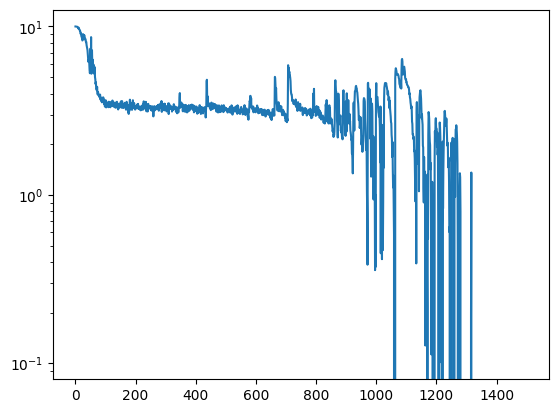

In [244]:
plt.semilogy(loss_history+10)
plt.show()

In [245]:
# res = np.asarray(res)
# plt.semilogy(res)
# plt.legend(['gu','ut', 'gu weight', 'ut weight'])
# plt.show()

# plt.plot(res)
# plt.legend(['gu','ut', 'gu weight', 'ut weight'])
# plt.show()

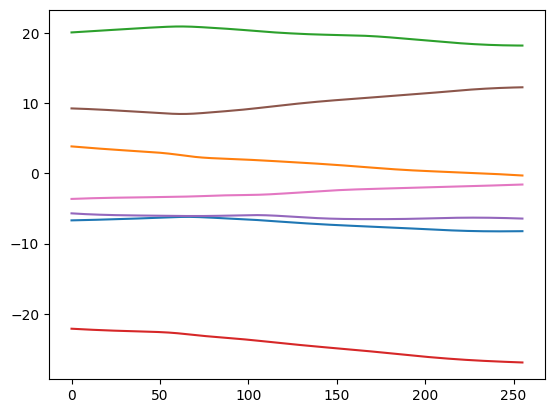

In [246]:
t_test = np.linspace(0,1.2,256)
states = generate_states(t_test, opt_params[0], opt_params[2])
plt.plot(states)
plt.show()

In [247]:
states.shape

(256, 7)

In [248]:
nx = 100
xA, xB = sols[:, :, 0].min(), sols[:, :, 0].max()
yA, yB = sols[:, :, 1].min(), sols[:, :, 1].max()
x1, x2 = jnp.linspace(xA, xB, nx), jnp.linspace(yA, yB, nx)
m_grids = jnp.meshgrid(x1, x2,  indexing='ij')
x_grid = jnp.asarray([m.flatten() for m in m_grids]).T


pred = []
for s in states[::10]:
    p = s_Vx(s, x_grid, opt_params[:2])
    pred.append(p.reshape(nx,nx))

pred = np.asarray(pred)
imshow_movie(pred, live_cbar=True)


In [249]:
def odeint_euler_maruyama_special(drift_fn, diff_fn, y0, t, states, key):
    @jit
    def em_fn(carry, t_state):
        t, state = t_state[0], t_state[1:]
        y, t_prev, key = carry
        dt = t - t_prev
        key, subkey = jax.random.split(key)
        drift = drift_fn(t_prev, y, state)
        diff = diff_fn(t_prev, y, subkey)
        y = y + dt * drift + jnp.sqrt(dt)*diff
        return (y, t, key), y
    
    t_states = jnp.hstack([t[:, None], states])
    (yf, _, _), y = jax.lax.scan(em_fn, (y0, jnp.array(t[0]), key), t_states)

    return y


In [250]:
sols.shape

(258, 10000, 2)

In [251]:
dt = 1e-2
t_int = np.arange(0,2,dt)
states = generate_states(t_int, opt_params[0], opt_params[2])

Nsol = 500
ic = sols[0, :Nsol]

def drift(t, y, state, *args):
    f = jnp.squeeze(s_dx_Vx(state, y, opt_params[:2]))
    return f

def diffusion(t, y, key):
    return sigma * jax.random.normal(key, shape=y.shape)

int_sol = odeint_euler_maruyama_special(drift, diffusion, ic, t_int, states, key)


In [243]:
scatter_movie(int_sol, t=t_int, xlim=[0,1], ylim=[0,1],)#,  save_to='/p/home/jmb/sc/rommc/roll_am', fps=5)